### Setup

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

df = pd.read_parquet('data/comments.parquet',columns=['id','rating'])

predictions_name_list = [
    'manual'
    ,'deepseek-r1:1.5b'
    ,'deepseek-r1:8b'
    ,'llama2:7b'
    ,'llama2:13b'
    ,'llama3.1'
    ,'llama3.2'
    ,'stablelm2:12b'
    ,'stablelm2'
]

for model in predictions_name_list:
    df_model = pd.read_parquet(f'data/pred_{model}.parquet', columns=['id', 'rating', 'prediction_time'])
    df_model.columns = [col+f'_{model}' for col in df_model.columns]
    df = df.merge(df_model, left_on='id', right_on=f'id_{model}', how='inner')
    df = df.drop(columns=f'id_{model}')
    df[f'inconsistent_{model}'] = (
        (df[f'rating_{model}'] - df['rating'] > 1)
        | (df[f'rating_{model}'] - df['rating'] < -1)
        ).astype(int)
    if model == 'manual':
        print(f'manual inputs: {len(df_model)}')

df['average_inconsistency'] = df[[col for col in df.columns if col.startswith('inconsistent_')]].mean(axis=1)
df.describe()

manual inputs: 328


,rating,rating_manual,prediction_time_manual,inconsistent_manual,rating_deepseek-r1:1.5b,prediction_time_deepseek-r1:1.5b,inconsistent_deepseek-r1:1.5b,rating_deepseek-r1:8b,prediction_time_deepseek-r1:8b,inconsistent_deepseek-r1:8b,...,rating_llama3.2,prediction_time_llama3.2,inconsistent_llama3.2,rating_stablelm2:12b,prediction_time_stablelm2:12b,inconsistent_stablelm2:12b,rating_stablelm2,prediction_time_stablelm2,inconsistent_stablelm2,average_inconsistency
count,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,...,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,327.000000,328.000000,328.000000,328.000000
mean,3.594512,3.320122,13.583705,0.143293,3.253049,26.737134,0.301829,3.237805,98.799756,0.128049,...,3.387195,4.285488,0.146341,3.923780,20.414177,0.219512,3.718654,32.615457,0.396341,0.183943
std,1.339896,0.966388,11.939767,0.350906,0.835008,17.724132,0.459753,0.997629,41.813013,0.334655,...,0.894814,2.080633,0.353988,0.504095,12.938997,0.414549,1.407818,18.434230,0.489884,0.189192
min,1.000000,1.000000,1.356035,0.000000,1.000000,9.380000,0.000000,1.000000,39.710000,0.000000,...,1.000000,2.820000,0.000000,1.000000,11.400000,0.000000,1.000000,9.790000,0.000000,0.000000
25%,3.000000,3.000000,5.897720,0.000000,3.000000,17.195000,0.000000,3.000000,69.720000,0.000000,...,3.000000,3.140000,0.000000,4.000000,12.250000,0.000000,3.000000,20.922500,0.000000,0.000000
50%,4.000000,3.000000,10.053677,0.000000,3.000000,22.630000,0.000000,3.000000,83.960000,0.000000,...,4.000000,3.545000,0.000000,4.000000,14.900000,0.000000,4.000000,30.865000,0.000000,0.111111
75%,5.000000,4.000000,17.233582,0.000000,4.000000,33.020000,1.000000,4.000000,121.090000,0.000000,...,4.000000,4.632500,0.000000,4.000000,23.897500,0.000000,5.000000,39.630000,1.000000,0.333333
max,5.000000,5.000000,98.388674,1.000000,5.000000,274.130000,1.000000,5.000000,332.700000,1.000000,...,5.000000,18.820000,1.000000,5.000000,84.280000,1.000000,5.000000,201.840000,1.000000,0.888889


### Models predictions <> Manual predictions

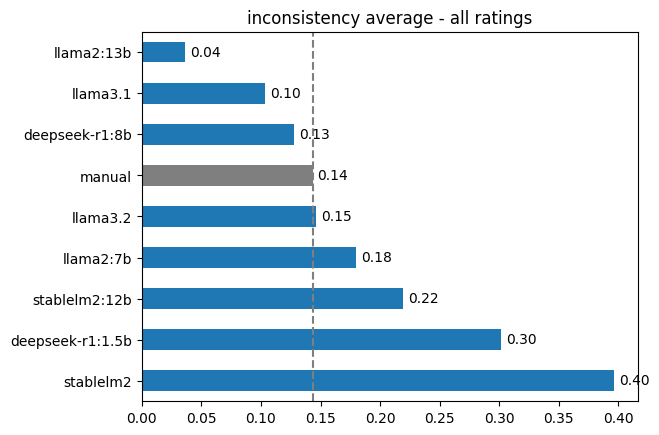

In [32]:
df_icts = df[[col for col in df.columns if col.startswith('inconsistent_')]]
df_icts.columns = [col.replace('inconsistent_', '') for col in df_icts.columns]
media = df_icts.mean().sort_values(ascending=False)

colors = ['C7' if idx == 'manual' else 'C0' for idx in media.index]
ax = media.plot(kind='barh', color=colors)
plt.title("inconsistency average - all ratings")
for i, v in enumerate(media):
    ax.text(v + 0.01 * media.max(), i, f"{v:.2f}", color='black', va='center')
manual_value = media.get("manual")
if manual_value is not None:
    ax.axvline(x=manual_value, color='C7', linestyle='--')
plt.show()

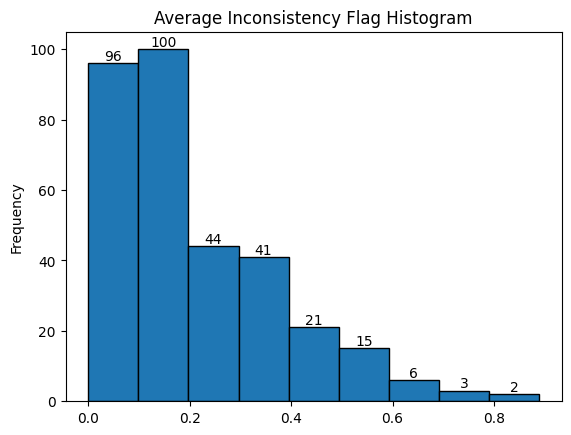

In [33]:
plt.figure()
counts, bins, patches = plt.hist(df['average_inconsistency'], bins=9, edgecolor='black')
plt.ylabel("Frequency")
plt.title("Average Inconsistency Flag Histogram")

bin_centers = 0.5 * (bins[1:] + bins[:-1])
for count, center in zip(counts, bin_centers):
    plt.text(center, count, str(int(count)), ha='center', va='bottom')

plt.show()

,Model,Accuracy,Precision,Recall,F1-Score,Confusion Matrix
1,deepseek-r1:8b,0.856707,0.500000,0.446809,0.471910,"[[260, 21], [26, 21]]"
2,llama2:7b,0.823171,0.406780,0.510638,0.452830,"[[246, 35], [23, 24]]"
0,deepseek-r1:1.5b,0.743902,0.313131,0.659574,0.424658,"[[213, 68], [16, 31]]"
4,llama3.1,0.844512,0.441176,0.319149,0.370370,"[[262, 19], [32, 15]]"
5,llama3.2,0.807927,0.333333,0.340426,0.336842,"[[249, 32], [31, 16]]"
7,stablelm2,0.582317,0.153846,0.425532,0.225989,"[[171, 110], [27, 20]]"
6,stablelm2:12b,0.698171,0.138889,0.212766,0.168067,"[[219, 62], [37, 10]]"
3,llama2:13b,0.832317,0.166667,0.042553,0.067797,"[[271, 10], [45, 2]]"


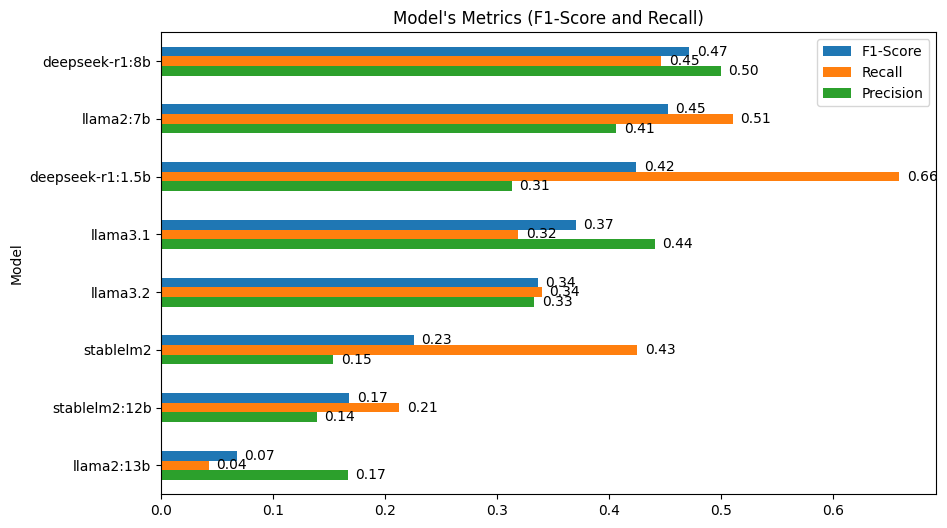

In [34]:
y_true = df['inconsistent_manual']
models = predictions_name_list[1:]

model_metrics_list = []
for model in models:
    y_pred = df[f'inconsistent_{model}']
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    model_metrics_list.append({
        'Model': model,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Confusion Matrix': cm
    })

model_metrics = pd.DataFrame(model_metrics_list).sort_values(by='F1-Score', ascending=False)
display(model_metrics)
model_metrics.set_index('Model', inplace=True)

metrics_graph = ['F1-Score', 'Recall', 'Precision']
ax = model_metrics[metrics_graph].plot(kind='barh', figsize=(10,6))
plt.title("Model's Metrics (F1-Score and Recall)")
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.01 * model_metrics[metrics_graph].max().max(),
            p.get_y() + p.get_height()/2,
            f"{width:.2f}",
            color='black', va='center')
ax.invert_yaxis()
plt.show()


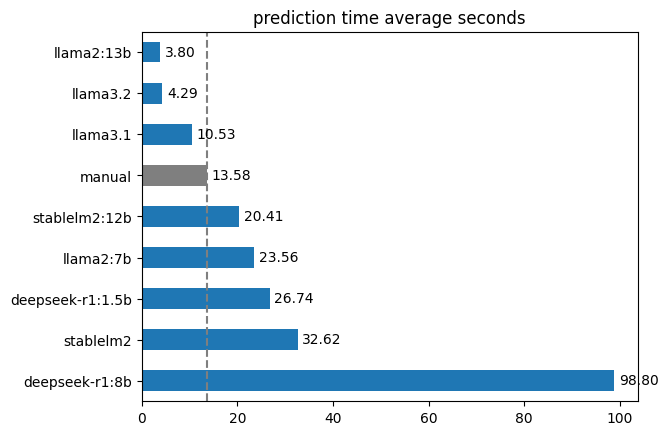

In [35]:
df_icts = df[[col for col in df.columns if col.startswith('prediction_time_')]]
df_icts.columns = [col.replace('prediction_time_', '') for col in df_icts.columns]
media = df_icts.mean().sort_values(ascending=False)

colors = ['C7' if idx == 'manual' else 'C0' for idx in media.index]
ax = media.plot(kind='barh', color=colors)
plt.title("prediction time average seconds")
for i, v in enumerate(media):
    ax.text(v + 0.01 * media.max(), i, f"{v:.2f}", color='black', va='center')
manual_value = media.get("manual")
if manual_value is not None:
    ax.axvline(x=manual_value, color='C7', linestyle='--')
plt.show()

In [ ]:
from openai import OpenAI
import json

example_prompt = """
You are a Sentiment Analysis Specialist, and your goal is to evaluate the following employee feedback and determine the overall rating based on the provided pros and cons:

Pros: Benefits provided are nice. Salary is okay.
Cons: Sometimes leadership is not the greatest. Too much powers are bestowed upon leaders

Rating scale (1 to 5):
    - 1: Extremely negative experience
    - 2: Negative experience
    - 3: Neutral or mixed experience
    - 4: Positive experience
    - 5: Extremely positive experience
"""

client = OpenAI(
  api_key=json.r
)

completion = client.chat.completions.create(
  model="gpt-4o-mini",
  store=True,
  messages=[
    {"role": "user",
     "content": example_prompt}
  ]
)

print(completion.choices[0].message.content)

from ollama import ChatResponse, chat
def llm_query(prompt: str, model: str) -> int:
    try:
        response: ChatResponse = chat(
            model=model,
            messages=[{'role': 'user','content': prompt}]
            )
        answer = str(response['message']['content']).strip()

        for char in reversed(answer):
            if char in ['1', '2', '3', '4', '5']:
                return int(char)
        return None
    
    except Exception as e:
        return None


3


In [10]:
import pandas as pd
df = pd.read_parquet('data/llm_predictions.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               81 non-null     object        
 1   model            81 non-null     object        
 2   temperature      81 non-null     float64       
 3   rating           81 non-null     int64         
 4   all_predictions  81 non-null     object        
 5   tries            81 non-null     int64         
 6   repeat_target    81 non-null     int64         
 7   prediction_time  81 non-null     float64       
 8   ts_prediction    81 non-null     datetime64[ns]
 9   processing_time  81 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 6.5+ KB


In [9]:
df = pd.read_parquet('data/llm_predictions.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               81 non-null     object        
 1   model            81 non-null     object        
 2   temperature      81 non-null     float64       
 3   rating           81 non-null     int64         
 4   all_predictions  81 non-null     object        
 5   tries            81 non-null     int64         
 6   repeat_target    81 non-null     int64         
 7   prediction_time  81 non-null     float64       
 8   ts_prediction    81 non-null     datetime64[ns]
 9   processing_time  81 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 6.5+ KB


In [4]:
df.head()

,id,model,temperature,rating,all_predictions,tries,repeat_target,prediction_time,ts_prediction,processing_time
0,8757471d27bd872e7f527b51f8b58d5fd74e51eed8a1ed...,deepseek-r1:1.5b,0.1,3,"[3, 3]",2,2,3.42,2025-03-30 15:59:52.454728,7.104530
1,49785720f30c061e8d9dc244c6cd981bc77aa413fa1154...,deepseek-r1:1.5b,0.1,5,"[5, 5]",2,2,3.52,2025-03-30 15:59:59.742100,7.287002
2,b934ab378e986960d36fd910edd92445489ad0103ba003...,deepseek-r1:1.5b,0.1,4,"[4, 4]",2,2,3.53,2025-03-30 16:00:09.840218,10.097691
3,2cef5de9a6828a9f5fe148d119c7ad8e127f934484b468...,deepseek-r1:1.5b,0.1,3,"[3, 3]",2,2,3.42,2025-03-30 16:00:17.656471,7.815827
4,89b510d253fb34210663a07dd3b3a2b00cadcecb119d9a...,deepseek-r1:1.5b,0.1,3,"[3, 3]",2,2,3.42,2025-03-30 16:00:26.876124,9.219227
